# (a) Catastrophic forgetting
### Learning digits without inhibition

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import torch
from torch import Tensor
import torch.nn as nn
import torch.cuda as cuda
import torch.utils.data as data_utils
from torch.utils.data import DataLoader, Dataset
from torch.nn.parameter import Parameter

try:
    import accimage
except ImportError:
    accimage = None

import random
import copy
import time

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.datasets import ImageFolder

from SpykeTorch import snn
from SpykeTorch import functional as sf
from SpykeTorch import visualization as vis
from SpykeTorch import utils

import struct
import glob
import datetime
import re

from sklearn.datasets import fetch_openml
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from PIL import Image

## Model

In [2]:
# model

class MozafariMNIST2018(nn.Module):
    
    def __init__(self):
        
        super(MozafariMNIST2018, self).__init__()

        self.conv1 = snn.Convolution(6, 30, 5, 0.8, 0.05)
        self.conv1_t = 15
        self.k1 = 5
        self.r1 = 0 #3

        self.conv2 = snn.Convolution(30, 250, 3, 0.8, 0.05)
        self.conv2_t = 10
        self.k2 = 8
        self.r2 = 0 #1

        self.conv3 = snn.Convolution(250, 200, 5, 0.8, 0.05)

        self.stdp1 = snn.STDP(self.conv1, (0.004, -0.003))
        self.stdp2 = snn.STDP(self.conv2, (0.004, -0.003))
        self.stdp3 = snn.STDP(self.conv3, (0.004, -0.003), False, 0.2, 0.8)
        self.anti_stdp3 = snn.STDP(self.conv3, (-0.004, 0.0005), False, 0.2, 0.8)
        self.max_ap = Parameter(torch.Tensor([0.15]))

        self.decision_map = []
        for i in range(10):
            self.decision_map.extend([i]*20)

        self.ctx = {"input_spikes":None, "potentials":None, "output_spikes":None, "winners":None}
        self.spk_cnt1 = 0
        self.spk_cnt2 = 0

    def forward(self, input, max_layer):
        
        input = sf.pad(input.float(), (2,2,2,2), 0)
        
        if self.training:
            pot = self.conv1(input)
            spk, pot = sf.fire(pot, self.conv1_t, True)
            if max_layer == 1:
                self.spk_cnt1 += 1
                if self.spk_cnt1 >= 500:
                    self.spk_cnt1 = 0
                    ap = torch.tensor(self.stdp1.learning_rate[0][0].item(), device=self.stdp1.learning_rate[0][0].device) * 2
                    ap = torch.min(ap, self.max_ap)
                    an = ap * -0.75
                    self.stdp1.update_all_learning_rate(ap.item(), an.item())
                pot = sf.pointwise_inhibition(pot)
                spk = pot.sign()
                winners = sf.get_k_winners(pot, self.k1, self.r1, spk)
                self.ctx["input_spikes"] = input
                self.ctx["potentials"] = pot
                self.ctx["output_spikes"] = spk
                self.ctx["winners"] = winners
                return spk, pot
            
            spk_in = sf.pad(sf.pooling(spk, 2, 2), (1,1,1,1))
            pot = self.conv2(spk_in)
            spk, pot = sf.fire(pot, self.conv2_t, True)
            if max_layer == 2:
                self.spk_cnt2 += 1
                if self.spk_cnt2 >= 500:
                    self.spk_cnt2 = 0
                    ap = torch.tensor(self.stdp2.learning_rate[0][0].item(), device=self.stdp2.learning_rate[0][0].device) * 2
                    ap = torch.min(ap, self.max_ap)
                    an = ap * -0.75
                    self.stdp2.update_all_learning_rate(ap.item(), an.item())
                pot = sf.pointwise_inhibition(pot)
                spk = pot.sign()
                winners = sf.get_k_winners(pot, self.k2, self.r2, spk)
                self.ctx["input_spikes"] = spk_in
                self.ctx["potentials"] = pot
                self.ctx["output_spikes"] = spk
                self.ctx["winners"] = winners
                return spk, pot
            
            spk_in = sf.pad(sf.pooling(spk, 3, 3), (2,2,2,2))
            pot = self.conv3(spk_in)
            spk = sf.fire(pot)
            winners = sf.get_k_winners(pot, 1, 0, spk)
            self.ctx["input_spikes"] = spk_in
            self.ctx["potentials"] = pot
            self.ctx["output_spikes"] = spk
            self.ctx["winners"] = winners
            output = -1
            if len(winners) != 0:
                output = self.decision_map[winners[0][0]]
            return output
        
        else:
            pot = self.conv1(input)
            spk, pot = sf.fire(pot, self.conv1_t, True)
            if max_layer == 1:
                return spk, pot
            
            pot = self.conv2(sf.pad(sf.pooling(spk, 2, 2), (1,1,1,1)))
            spk, pot = sf.fire(pot, self.conv2_t, True)
            if max_layer == 2:
                return spk, pot
            pot = self.conv3(sf.pad(sf.pooling(spk, 3, 3), (2,2,2,2)))
            spk = sf.fire(pot)
            winners = sf.get_k_winners(pot, 1, 0, spk)
            output = -1
            if len(winners) != 0:
                output = self.decision_map[winners[0][0]]
            return output

    def stdp(self, layer_idx):
        if layer_idx == 1:
            self.stdp1(self.ctx["input_spikes"], self.ctx["potentials"], self.ctx["output_spikes"], self.ctx["winners"])
        if layer_idx == 2:
            self.stdp2(self.ctx["input_spikes"], self.ctx["potentials"], self.ctx["output_spikes"], self.ctx["winners"])

    def update_learning_rates(self, stdp_ap, stdp_an, anti_stdp_ap, anti_stdp_an):
        self.stdp3.update_all_learning_rate(stdp_ap, stdp_an)
        self.anti_stdp3.update_all_learning_rate(anti_stdp_an, anti_stdp_ap)

    def reward(self):
        self.stdp3(self.ctx["input_spikes"], self.ctx["potentials"], self.ctx["output_spikes"], self.ctx["winners"])

    def punish(self):
        self.anti_stdp3(self.ctx["input_spikes"], self.ctx["potentials"], self.ctx["output_spikes"], self.ctx["winners"])


In [3]:
# train and test

def train_unsupervise(network, data, layer_idx):
    network.train()
    
    for i in range(len(data)):
        data_in = data[i]
        if use_cuda:
            data_in = data_in.cuda()
        network(data_in, layer_idx)
        network.stdp(layer_idx)

def train_rl(network, data, target):
    network.train()
    perf = np.array([0,0,0]) # correct, wrong, silence
    for i in range(len(data)):
        data_in = data[i]
        target_in = target[i]
        if use_cuda:
            data_in = data_in.cuda()
            target_in = target_in.cuda()
        d = network(data_in, 3)
        if d != -1:
            if d == target_in:
                perf[0]+=1
                network.reward()
            else:
                perf[1]+=1
                network.punish()
        else:
            perf[2]+=1
    return perf/len(data)

def test(network, data, target):
    network.eval()
    perf = np.array([0,0,0]) # correct, wrong, silence
    for i in range(len(data)):
        data_in = data[i]
        target_in = target[i]
        if use_cuda:
            data_in = data_in.cuda()
            target_in = target_in.cuda()
        d = network(data_in, 3)
        if d != -1:
            if d == target_in:
                perf[0]+=1
            else:
                perf[1]+=1
        else:
            perf[2]+=1
    return perf/len(data)

In [4]:
def curve_graph(parametr_set):

    plt.subplots(figsize=(15, 5))

    plt.plot(parametr_set['epoch'], parametr_set['train']*100, color='cyan', label='train')
    plt.plot(parametr_set['epoch'], parametr_set['test']*100, color='blue', marker = 'o', label='test')
    plt.plot(parametr_set['epoch'], parametr_set['test_previous']*100, linestyle = ':', color='red', label='test of previous images')
    plt.xlabel('epochs', loc='right', fontsize=17)
    plt.ylabel('accuracy, %',  loc='top', fontsize=17)
    plt.grid()
    plt.legend()
    plt.show()

In [5]:
# training of 3-rd layer

def third_layer(file_name_net, file_name_csv, adaptive_int, previous_epochs, epochs, 
                train_loader, test_loader, test_previous_loader,
                model, apr, anr, app, anp, parametr_set, steps=None, percent=20, it_continues=False):  
    
    '''
    file_name_net - name of file for saving state_dict of model
    file_name_csv - name of file for saving parameters of model in each epoch
    adaptive_int - learning rate parameter
    previous_epochs - if before model had training in current period
    it_continues - is it continue of 3-rd layer training or not (False or True)
    percent - percent of moving weights (calculated from the number of high range weights)
    '''

    adaptive_min=0 

    if not it_continues:

        previous_epochs = 0
        counter = 0

        apr_adapt = ((1.0 - 1.0 / 10) * adaptive_int + adaptive_min) * apr
        anr_adapt = ((1.0 - 1.0 / 10) * adaptive_int + adaptive_min) * anr
        app_adapt = ((1.0 / 10) * adaptive_int + adaptive_min) * app
        anp_adapt = ((1.0 / 10) * adaptive_int + adaptive_min) * anp
        
        best_train = np.array([0.0,0.0,0.0,0.0]) # correct, wrong, silence, epoch
        best_test = np.array([0.0,0.0,0.0,0.0]) # correct, wrong, silence, epoch
        best_test_previous = np.array([0.0,0.0,0.0,0.0]) # correct, wrong, silence, epoch

    else:
      
        if len(parametr_set.loc[parametr_set['test'] == parametr_set['test'].max(), 'epoch']) == 1:
            optim_index = int(parametr_set.loc[parametr_set['test'] == parametr_set['test'].max(), 'epoch'].item())
        else:
            optim_index = int(parametr_set.loc[parametr_set['test'] == parametr_set['test'].max(), 'epoch'].tolist()[-1])

        if len(parametr_set.loc[parametr_set['train'] == parametr_set['train'].max(), 'epoch']) == 1:
            best_train_index = int(parametr_set.loc[parametr_set['train'] == parametr_set['train'].max(), 'epoch'].item())
        else:
            best_train_index = int(parametr_set.loc[parametr_set['train'] == parametr_set['train'].max(), 'epoch'].tolist()[-1])

        if len(parametr_set.loc[parametr_set['test_previous'] == parametr_set['test_previous'].max(), 'epoch']) == 1:
            best_test_previous_index = int(parametr_set.loc[parametr_set['test_previous'] == parametr_set['test_previous'].max(), 'epoch'].item())
        else:
            best_test_previous_index = int(parametr_set.loc[parametr_set['test_previous'] == parametr_set['test_previous'].max(), 'epoch'].tolist()[-1])
        
        max_index = int(parametr_set.index.max())
        counter = (max_index + 1)

        param_best_train = parametr_set['train'].iloc[best_train_index]
        param_best_test = parametr_set['test'].iloc[optim_index]
        param_best_test_previous = parametr_set['test_previous'].iloc[best_test_previous_index]

        apr_adapt = parametr_set['apr_adapt'].iloc[optim_index]
        anr_adapt = parametr_set['anr_adapt'].iloc[optim_index]
        app_adapt = parametr_set['app_adapt'].iloc[optim_index]
        anp_adapt = parametr_set['anp_adapt'].iloc[optim_index]
        
        for i in range(len(mozafari.stdp3.learning_rate)):
            mozafari.stdp3.learning_rate[i][0].fill_(parametr_set['stdp3.learning_rate[0]'].iloc[optim_index])
            mozafari.stdp3.learning_rate[i][1].fill_(parametr_set['stdp3.learning_rate[1]'].iloc[optim_index])
            mozafari.anti_stdp3.learning_rate[0][0].fill_(parametr_set['anti_stdp3.learning_rate[0]'].iloc[optim_index])
            mozafari.anti_stdp3.learning_rate[0][0].fill_(parametr_set['anti_stdp3.learning_rate[1]'].iloc[optim_index])

        best_train = np.array([param_best_train,1-param_best_train,0.0,best_train_index]) # correct, wrong, silence, epoch
        best_test = np.array([param_best_test,1-param_best_test,0.0,optim_index]) # correct, wrong, silence, epoch
        best_test_previous = np.array([param_best_test_previous,1-param_best_test_previous,0.0,best_test_previous_index]) # correct, wrong, silence, epoch
    
    # list of 3-rd layer weights

    dim_0, dim_1, dim_2, dim_3 = tuple(mozafari.conv3.weight.size())
    total_size = dim_0 * dim_1 * dim_2 * dim_3
  
    # indexes of weights
    indexes_i = []    
    indexes_j = []        
    indexes_k = []        
    indexes_m = []    
    
    # values of weights
    item_values = []  
    
    for i in range(dim_0):
        for j in range(dim_1):
            for k in range(dim_2):
                for m in range(dim_3):
                    indexes_i.append(i)
                    indexes_j.append(j)
                    indexes_k.append(k)
                    indexes_m.append(m)
                    item_values.append(mozafari.conv3.weight[i][j][k][m].item())

    indexes_dim_0 = pd.Series(indexes_i, name='dim_0') 
    indexes_dim_1 = pd.Series(indexes_j, name='dim_1')
    indexes_dim_2 = pd.Series(indexes_k, name='dim_2')
    indexes_dim_3 = pd.Series(indexes_m, name='dim_3')
    item_values = pd.Series(item_values, name='value_0')
            
    conv3_data = pd.concat([item_values, indexes_dim_0, indexes_dim_1, indexes_dim_2, indexes_dim_3], axis=1)
    
    high_percent = 85 #percent of high range weights
    percentile_value = np.percentile(item_values, high_percent)
    
    conv3_data['low_range_0'] = 0
    conv3_data.loc[conv3_data['value_0'] < percentile_value,'low_range_0'] = 1
    
    try:
        high_range_counter = conv3_data['low_range_0'].value_counts()[0] 
    except:
        high_range_counter = 1
 
    moving_quantity = int((percent/100)*high_range_counter) #quantity of moving items in each epoch
    
    if steps is None:
        steps = int(total_size*high_percent/(100*moving_quantity))   #steps of weights moving 
    print(f'Weight moving will be during {steps} epochs')
    
    for epoch in range(epochs):
        
        seconds_epoch_0 = time.time() 
        
        print('-'*50)
        print("Epoch #: ", epoch + previous_epochs)
        
        perf_train = np.array([0.0,0.0,0.0]) 
        
        for data,targets in train_loader:
                
            if epoch < steps: 
                
                print(f'Values of high range weights in epoch#{epoch} [{percentile_value :.3f}:0.800] (top {100-high_percent}%)')
                low_range_indexes = list(conv3_data.index[conv3_data['low_range_'+str(epoch)] == 1])
                moving_items = random.sample(low_range_indexes, np.minimum(moving_quantity, len(low_range_indexes)))
                moving_indexes = conv3_data.loc[conv3_data.index.isin(moving_items)]

                print(f'Quantity of moving points in epoch#{epoch + previous_epochs} = {len(moving_indexes.index)} items' 
                      f' ({len(moving_indexes.index)/(total_size-high_range_counter)*100 :.1f}% of moving points)')

                for q in range(len(moving_indexes.index)):
                    mozafari.conv3.weight \
                    [moving_indexes['dim_0'].iloc[q]][moving_indexes['dim_1'].iloc[q]][moving_indexes['dim_2'].iloc[q]][moving_indexes['dim_3'].iloc[q]]. \
                    fill_(np.random.normal(loc=0.8, scale=0.05))  
              
            perf_train_batch = train_rl(model, data, targets)
    
            if epoch < steps:  
            
                # new values of weights (after learning)
                item_values = []       
                for i in range(dim_0):
                    for j in range(dim_1):
                        for k in range(dim_2):
                            for m in range(dim_3):
                                item_values.append(mozafari.conv3.weight[i][j][k][m].item())
            
                item_values = pd.Series(item_values, name='value_'+str(epoch+1))
                percentile_value = np.percentile(item_values, high_percent) #new cutting off high range weights
                conv3_data = pd.concat([conv3_data, item_values], axis=1)
                
                conv3_data['low_range_'+str(epoch+1)] = 0
                conv3_data.loc[conv3_data['value_'+str(epoch+1)] < percentile_value,'low_range_'+str(epoch+1)] = 1
       
            #update adaptive learning rates
            apr_adapt = apr * (perf_train_batch[1] * adaptive_int + adaptive_min)
            anr_adapt = anr * (perf_train_batch[1] * adaptive_int + adaptive_min)
            app_adapt = app * (perf_train_batch[0] * adaptive_int + adaptive_min)
            anp_adapt = anp * (perf_train_batch[0] * adaptive_int + adaptive_min)
            parametr_set.loc[counter, 'epoch'] = epoch + previous_epochs
            parametr_set.loc[counter, 'apr_adapt'] = apr_adapt
            parametr_set.loc[counter, 'anr_adapt'] = anr_adapt
            parametr_set.loc[counter, 'app_adapt'] = app_adapt
            parametr_set.loc[counter, 'anp_adapt'] = anp_adapt
            parametr_set.loc[counter, 'stdp3.learning_rate[0]'] = mozafari.stdp3.learning_rate[0][0].item()
            parametr_set.loc[counter, 'stdp3.learning_rate[1]'] = mozafari.stdp3.learning_rate[0][1].item()
            parametr_set.loc[counter, 'anti_stdp3.learning_rate[0]'] = mozafari.anti_stdp3.learning_rate[0][0].item()
            parametr_set.loc[counter, 'anti_stdp3.learning_rate[1]'] = mozafari.anti_stdp3.learning_rate[0][1].item()
            parametr_set.loc[counter, 'train'] = perf_train_batch[0]

            model.update_learning_rates(apr_adapt, anr_adapt, app_adapt, anp_adapt)
            perf_train += perf_train_batch
            
        perf_train /= len(train_loader)

        if best_train[0] <= perf_train[0]:
            best_train = np.append(perf_train, epoch + previous_epochs)
        print(f"Current Train: {perf_train[0]*100 :.2f}%")
        #print("   Best Train:", best_train)

        for data,targets in test_loader:
            perf_test = test(model, data, targets)
            parametr_set.loc[counter, 'test'] = perf_test[0]
            if best_test[0] <= perf_test[0]:
                best_test = np.append(perf_test, epoch + previous_epochs)
                torch.save(model.state_dict(), file_name_net)
            print(f"Current Test: {perf_test[0]*100 :.2f}%")
            #print("    Best Test:", best_test)

        if isinstance(test_previous_loader, DataLoader):
            for data,targets in test_previous_loader:
                perf_test_previous = test(model, data, targets)
                parametr_set.loc[counter, 'test_previous'] = perf_test_previous[0]
                if best_test_previous[0] <= perf_test_previous[0]:
                    best_test_previous = np.append(perf_test_previous, epoch + previous_epochs)
                print(f"Current Test Previous: {perf_test_previous[0]*100 :.2f}%")
                #print("    Best Test Previous:", best_test_previous)
                
        else:
            parametr_set.loc[counter, 'test_previous'] = 0
            
        counter += 1
                                                 
        seconds_epoch_1 = time.time()  
        print(f'Operational time of epoch #{epoch + previous_epochs}: '
                  f'{int((seconds_epoch_1 - seconds_epoch_0)//60)} min {int((seconds_epoch_1 - seconds_epoch_0)%60)} sec') 
    
    parametr_set.to_csv(file_name_csv)
    
    print('=='*10, 'SUMMARY', '=='*10)
    print(f"        Best Train: {best_train[0]*100 :.2f}% on {best_train[3] :.0f} epoch")
    print(f"         Best Test: {best_test[0]*100 :.2f}% on {best_test[3] :.0f} epoch")
    print(f"Best Test Previous: {best_test_previous[0]*100 :.2f}% on {best_test_previous[3] :.0f} epoch")
    
    return parametr_set, counter, (previous_epochs+epochs), apr, anr, app, anp, conv3_data

In [6]:
# for image transformation (see dataset)

class S1C1Transform:
    
    def __init__(self, filter, PIL_type=False, timesteps = 15):
        self.PIL_type = PIL_type
        self.to_pil_image = transforms.ToPILImage()    
        self.to_tensor = transforms.ToTensor()
        self.filter = filter
        self.temporal_transform = utils.Intensity2Latency(timesteps)
        self.cnt = 0
        
    def __call__(self, image):
        if self.cnt % 10000 == 0:
            print(f'{self.cnt} images')
        if self.PIL_type:
            image = self.to_pil_image(image)
        self.cnt+=1
        image = self.to_tensor(image) * 255
        image.unsqueeze_(0)
        image = self.filter(image)
        image = sf.local_normalization(image, 8)
        temporal_image = self.temporal_transform(image)
        return temporal_image.sign().byte()

In [7]:
# for image transformation (see dataset)

kernels = [ utils.DoGKernel(3,3/9,6/9),
            utils.DoGKernel(3,6/9,3/9),
            utils.DoGKernel(7,7/9,14/9),
            utils.DoGKernel(7,14/9,7/9),
            utils.DoGKernel(13,13/9,26/9),
            utils.DoGKernel(13,26/9,13/9)]

filter = utils.Filter(kernels, padding = 6, thresholds = 50)

s1c1 = S1C1Transform(filter)
s1c1_PIL = S1C1Transform(filter, PIL_type=True)

In [8]:
# for image transformation (see dataset)

class CustomTensorDataset(Dataset):
    """TensorDataset with support of transforms."""
    
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)

## Sets

### Set of 10 capital letters
24000 train images + 4000 test images

In [10]:
# set of 10 capital letters from EMNIST

path = f'./data/EMNIST_own/capital_letters/'

test_letter_labels = torch.load(f'{path}Mozafari_capital_letters_test_labels.pt', map_location=torch.device('cpu'))
test_letters = torch.load(f'{path}Mozafari_capital_letters_test_images.pt', map_location=torch.device('cpu'))

train_letter_labels = torch.load(f'{path}Mozafari_capital_letters_train_labels.pt', map_location=torch.device('cpu'))
train_letters = torch.load(f'{path}Mozafari_capital_letters_train_images.pt', map_location=torch.device('cpu'))

In [11]:
# Element permutation

train_order_l = torch.randperm(train_letter_labels.shape[0])
test_order_l = torch.randperm(test_letter_labels.shape[0])

train_letter_labels = train_letter_labels[train_order_l].view(train_letter_labels.size())
train_letters = train_letters[train_order_l].view(train_letters.size())

test_letter_labels = test_letter_labels[test_order_l].view(test_letter_labels.size())
test_letters = test_letters[test_order_l].view(test_letters.size())

In [12]:
train_letter_set = CustomTensorDataset(tensors=(train_letters, train_letter_labels), transform=s1c1_PIL)
test_letter_set = CustomTensorDataset(tensors=(test_letters, test_letter_labels), transform=s1c1_PIL)

train_letter_loader = DataLoader(train_letter_set, batch_size=len(train_letter_set))
test_letter_loader = DataLoader(test_letter_set, batch_size=len(test_letter_set))

In [13]:
train_letter_labels.size(), test_letter_labels.size()

(torch.Size([24000]), torch.Size([4000]))

### Set of 10 MNIST digits
Reduction 60000 train + 10000 test images to 24000 train + 4000 test images

In [14]:
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [15]:
# the set of 10 digit images, the same size as the set of letters (2400 trains + 400 tests per class)

# the MNIST data was pre-divided into 10 classes
path = f'./data/MNIST_0_1_2_3_4_5_6_7_8_9/'

for i in classes: 
    globals()[f'train_digit_{i}_images'] = torch.load(f'{path}train_images_{i}.pt', map_location=torch.device('cpu'))[0:2400]
    globals()[f'train_digit_{i}_labels'] = torch.load(f'{path}train_labels_{i}.pt', map_location=torch.device('cpu'))[0:2400]
    globals()[f'test_digit_{i}_images'] = torch.load(f'{path}test_images_{i}.pt', map_location=torch.device('cpu'))[0:400]
    globals()[f'test_digit_{i}_labels'] = torch.load(f'{path}test_labels_{i}.pt', map_location=torch.device('cpu'))[0:400]

train_MNIST_labels = globals()[f'train_digit_0_labels']
train_MNIST_images = globals()[f'train_digit_0_images']
test_MNIST_labels = globals()[f'test_digit_0_labels']
test_MNIST_images = globals()[f'test_digit_0_images']                                 

for i in range(1, 10):
    train_MNIST_labels = torch.cat((train_MNIST_labels, globals()[f'train_digit_{i}_labels']), 0)
    train_MNIST_images = torch.cat((train_MNIST_images, globals()[f'train_digit_{i}_images']), 0)

    test_MNIST_labels = torch.cat((test_MNIST_labels, globals()[f'test_digit_{i}_labels']), 0)
    test_MNIST_images = torch.cat((test_MNIST_images, globals()[f'test_digit_{i}_images']), 0)

In [16]:
train_MNIST_labels.size(), test_MNIST_labels.size()

(torch.Size([24000]), torch.Size([4000]))

In [17]:
# Element permutation

train_order = torch.randperm(train_MNIST_labels.shape[0])
test_order = torch.randperm(test_MNIST_labels.shape[0])

train_MNIST_labels = train_MNIST_labels[train_order].view(train_MNIST_labels.size())
train_MNIST_images = train_MNIST_images[train_order].view(train_MNIST_images.size())

test_MNIST_labels = test_MNIST_labels[test_order].view(test_MNIST_labels.size())
test_MNIST_images = test_MNIST_images[test_order].view(test_MNIST_images.size())

In [18]:
train_MNIST_set = CustomTensorDataset(tensors=(train_MNIST_images, train_MNIST_labels), transform=s1c1_PIL)
test_MNIST_set = CustomTensorDataset(tensors=(test_MNIST_images, test_MNIST_labels), transform=s1c1_PIL)

train_MNIST_loader = DataLoader(train_MNIST_set, batch_size=len(train_MNIST_set))
test_MNIST_loader = DataLoader(test_MNIST_set, batch_size=len(test_MNIST_set))

## Model activation

In [19]:
mozafari = MozafariMNIST2018()

In [20]:
use_cuda = True

if torch.cuda.is_available():
    print("CUDA is available")
    device = torch.device("cuda")

CUDA is available


In [21]:
if use_cuda:
    mozafari.cuda()   
#mozafari.to(device)
mozafari.eval()

MozafariMNIST2018(
  (conv1): Convolution()
  (conv2): Convolution()
  (conv3): Convolution()
  (stdp1): STDP(
    (conv_layer): Convolution()
  )
  (stdp2): STDP(
    (conv_layer): Convolution()
  )
  (stdp3): STDP(
    (conv_layer): Convolution()
  )
  (anti_stdp3): STDP(
    (conv_layer): Convolution()
  )
)

## Initial training 
### without inhibition (radius_inhibition = 0 in layers 1, 2, 3)

### Training the first layer

In [22]:
print("Training the first layer")

for epoch in range(2):
    print("Epoch", epoch)
    iter = 0
    for data, targets in train_MNIST_loader:
        print("Iteration", iter)
        train_unsupervise(mozafari, data, 1)
        print("Done!")
        iter+=1

Training the first layer
Epoch 0
0 images
10000 images
20000 images
Iteration 0
Done!
Epoch 1
30000 images
40000 images
Iteration 0
Done!


### Training the second layer

In [23]:
print("Training the second layer")

for epoch in range(4):
    print("Epoch", epoch)
    iter = 0
    for data,targets in train_MNIST_loader:
        print("Iteration", iter)
        train_unsupervise(mozafari, data, 2)
        print("Done!")
        iter+=1

Training the second layer
Epoch 0
50000 images
60000 images
70000 images
Iteration 0
Done!
Epoch 1
80000 images
90000 images
Iteration 0
Done!
Epoch 2
100000 images
110000 images
Iteration 0
Done!
Epoch 3
120000 images
130000 images
140000 images
Iteration 0
Done!


### Training the third layer

In [24]:
# initial adaptive learning rates

apr = mozafari.stdp3.learning_rate[0][0].item()
anr = mozafari.stdp3.learning_rate[0][1].item()
app = mozafari.anti_stdp3.learning_rate[0][1].item()
anp = mozafari.anti_stdp3.learning_rate[0][0].item()
               
parametr_set = pd.DataFrame(columns=['epoch', 'train', 'test', 'test_previous',   
                                 'apr_adapt', 'anr_adapt', 'app_adapt', 'anp_adapt', 
                                 'stdp3.learning_rate[0]', 'stdp3.learning_rate[1]',
                                 'anti_stdp3.learning_rate[0]', 'anti_stdp3.learning_rate[1]'])

In [25]:
first_test = third_layer(file_name_net="saved_24000_digits_(without_inhibition)_0.net",
                        file_name_csv='parameter_set_24000_digits_(without_inhibition)_0.csv',
                        adaptive_int=1, previous_epochs=0, epochs=600, 
                        train_loader=train_MNIST_loader, 
                        test_loader=test_MNIST_loader, 
                        test_previous_loader=[],
                        model=mozafari, apr=apr, anr=anr, app=app, anp=anp, 
                        parametr_set=parametr_set, steps=0, percent=0, it_continues=False)

parametr_set = first_test[0] 
counter = first_test[1] 
previous_epochs = first_test[2]
apr = first_test[3] 
anr = first_test[4] 
app = first_test[5] 
anp = first_test[6]
conv3_data_train = first_test[7]

Weight moving will be during 0 epochs
--------------------------------------------------
Epoch #:  0
150000 images
160000 images
Current Train: 61.04%
170000 images
Current Test: 66.10%
Operational time of epoch #0: 1 min 48 sec
--------------------------------------------------
Epoch #:  1
180000 images
190000 images
Current Train: 72.75%
Current Test: 71.23%
Operational time of epoch #1: 1 min 48 sec
--------------------------------------------------
Epoch #:  2
200000 images
210000 images
220000 images
Current Train: 76.28%
Current Test: 74.98%
Operational time of epoch #2: 1 min 51 sec
--------------------------------------------------
Epoch #:  3
230000 images
240000 images
250000 images
Current Train: 79.56%
Current Test: 78.30%
Operational time of epoch #3: 1 min 47 sec
--------------------------------------------------
Epoch #:  4
260000 images
270000 images
Current Train: 80.66%
280000 images
Current Test: 80.27%
Operational time of epoch #4: 1 min 47 sec
---------------------

1350000 images
1360000 images
1370000 images
Current Train: 93.28%
Current Test: 90.77%
Operational time of epoch #43: 1 min 46 sec
--------------------------------------------------
Epoch #:  44
1380000 images
1390000 images
Current Train: 93.42%
1400000 images
Current Test: 90.72%
Operational time of epoch #44: 1 min 46 sec
--------------------------------------------------
Epoch #:  45
1410000 images
1420000 images
Current Train: 93.41%
1430000 images
Current Test: 90.72%
Operational time of epoch #45: 1 min 47 sec
--------------------------------------------------
Epoch #:  46
1440000 images
1450000 images
Current Train: 93.46%
Current Test: 90.97%
Operational time of epoch #46: 1 min 47 sec
--------------------------------------------------
Epoch #:  47
1460000 images
1470000 images
1480000 images
Current Train: 93.57%
Current Test: 90.67%
Operational time of epoch #47: 1 min 47 sec
--------------------------------------------------
Epoch #:  48
1490000 images
1500000 images
15100

2560000 images
2570000 images
Current Train: 94.99%
Current Test: 91.55%
Operational time of epoch #86: 1 min 55 sec
--------------------------------------------------
Epoch #:  87
2580000 images
2590000 images
2600000 images
Current Train: 95.01%
Current Test: 91.92%
Operational time of epoch #87: 1 min 48 sec
--------------------------------------------------
Epoch #:  88
2610000 images
2620000 images
2630000 images
Current Train: 94.96%
Current Test: 91.57%
Operational time of epoch #88: 1 min 48 sec
--------------------------------------------------
Epoch #:  89
2640000 images
2650000 images
Current Train: 95.02%
2660000 images
Current Test: 91.60%
Operational time of epoch #89: 1 min 48 sec
--------------------------------------------------
Epoch #:  90
2670000 images
2680000 images
Current Train: 95.20%
2690000 images
Current Test: 91.75%
Operational time of epoch #90: 1 min 48 sec
--------------------------------------------------
Epoch #:  91
2700000 images
2710000 images
Curre

Current Train: 95.93%
Current Test: 91.90%
Operational time of epoch #128: 1 min 48 sec
--------------------------------------------------
Epoch #:  129
3760000 images
3770000 images
Current Train: 96.00%
3780000 images
Current Test: 92.10%
Operational time of epoch #129: 1 min 48 sec
--------------------------------------------------
Epoch #:  130
3790000 images
3800000 images
Current Train: 95.87%
3810000 images
Current Test: 92.17%
Operational time of epoch #130: 1 min 47 sec
--------------------------------------------------
Epoch #:  131
3820000 images
3830000 images
Current Train: 95.95%
Current Test: 92.20%
Operational time of epoch #131: 1 min 47 sec
--------------------------------------------------
Epoch #:  132
3840000 images
3850000 images
3860000 images
Current Train: 95.94%
Current Test: 92.05%
Operational time of epoch #132: 1 min 47 sec
--------------------------------------------------
Epoch #:  133
3870000 images
3880000 images
3890000 images
Current Train: 95.77%
Cur

4930000 images
Current Test: 92.42%
Operational time of epoch #170: 1 min 47 sec
--------------------------------------------------
Epoch #:  171
4940000 images
4950000 images
Current Train: 96.31%
Current Test: 92.27%
Operational time of epoch #171: 1 min 47 sec
--------------------------------------------------
Epoch #:  172
4960000 images
4970000 images
4980000 images
Current Train: 96.29%
Current Test: 92.33%
Operational time of epoch #172: 1 min 47 sec
--------------------------------------------------
Epoch #:  173
4990000 images
5000000 images
5010000 images
Current Train: 96.33%
Current Test: 92.22%
Operational time of epoch #173: 1 min 47 sec
--------------------------------------------------
Epoch #:  174
5020000 images
5030000 images
Current Train: 96.22%
5040000 images
Current Test: 92.45%
Operational time of epoch #174: 1 min 47 sec
--------------------------------------------------
Epoch #:  175
5050000 images
5060000 images
Current Train: 96.38%
5070000 images
Current Te

Current Test: 92.27%
Operational time of epoch #212: 1 min 46 sec
--------------------------------------------------
Epoch #:  213
6110000 images
6120000 images
6130000 images
Current Train: 96.67%
Current Test: 92.65%
Operational time of epoch #213: 1 min 46 sec
--------------------------------------------------
Epoch #:  214
6140000 images
6150000 images
Current Train: 96.70%
6160000 images
Current Test: 92.38%
Operational time of epoch #214: 1 min 46 sec
--------------------------------------------------
Epoch #:  215
6170000 images
6180000 images
Current Train: 96.71%
6190000 images
Current Test: 92.67%
Operational time of epoch #215: 1 min 47 sec
--------------------------------------------------
Epoch #:  216
6200000 images
6210000 images
Current Train: 96.78%
Current Test: 92.50%
Operational time of epoch #216: 1 min 47 sec
--------------------------------------------------
Epoch #:  217
6220000 images
6230000 images
6240000 images
Current Train: 96.73%
Current Test: 92.65%
Oper

Current Test: 92.73%
Operational time of epoch #254: 1 min 48 sec
--------------------------------------------------
Epoch #:  255
7290000 images
7300000 images
Current Train: 97.00%
7310000 images
Current Test: 92.55%
Operational time of epoch #255: 1 min 48 sec
--------------------------------------------------
Epoch #:  256
7320000 images
7330000 images
Current Train: 96.94%
Current Test: 92.55%
Operational time of epoch #256: 1 min 48 sec
--------------------------------------------------
Epoch #:  257
7340000 images
7350000 images
7360000 images
Current Train: 96.90%
Current Test: 92.73%
Operational time of epoch #257: 1 min 48 sec
--------------------------------------------------
Epoch #:  258
7370000 images
7380000 images
7390000 images
Current Train: 97.00%
Current Test: 92.58%
Operational time of epoch #258: 1 min 48 sec
--------------------------------------------------
Epoch #:  259
7400000 images
7410000 images
Current Train: 97.02%
7420000 images
Current Test: 92.53%
Oper

8470000 images
8480000 images
Current Train: 97.08%
Current Test: 92.85%
Operational time of epoch #297: 1 min 47 sec
--------------------------------------------------
Epoch #:  298
8490000 images
8500000 images
8510000 images
Current Train: 97.16%
Current Test: 92.65%
Operational time of epoch #298: 1 min 48 sec
--------------------------------------------------
Epoch #:  299
8520000 images
8530000 images
Current Train: 97.12%
8540000 images
Current Test: 92.97%
Operational time of epoch #299: 1 min 48 sec
--------------------------------------------------
Epoch #:  300
8550000 images
8560000 images
Current Train: 97.16%
8570000 images
Current Test: 92.62%
Operational time of epoch #300: 1 min 47 sec
--------------------------------------------------
Epoch #:  301
8580000 images
8590000 images
Current Train: 97.17%
Current Test: 92.88%
Operational time of epoch #301: 1 min 47 sec
--------------------------------------------------
Epoch #:  302
8600000 images
8610000 images
8620000 im

9650000 images
Current Train: 97.28%
9660000 images
Current Test: 92.83%
Operational time of epoch #339: 1 min 48 sec
--------------------------------------------------
Epoch #:  340
9670000 images
9680000 images
Current Train: 97.22%
9690000 images
Current Test: 92.65%
Operational time of epoch #340: 1 min 48 sec
--------------------------------------------------
Epoch #:  341
9700000 images
9710000 images
Current Train: 97.29%
Current Test: 92.77%
Operational time of epoch #341: 1 min 48 sec
--------------------------------------------------
Epoch #:  342
9720000 images
9730000 images
9740000 images
Current Train: 97.30%
Current Test: 92.70%
Operational time of epoch #342: 1 min 48 sec
--------------------------------------------------
Epoch #:  343
9750000 images
9760000 images
9770000 images
Current Train: 97.30%
Current Test: 92.95%
Operational time of epoch #343: 1 min 48 sec
--------------------------------------------------
Epoch #:  344
9780000 images
9790000 images
Current Tr

10820000 images
10830000 images
Current Train: 97.37%
Current Test: 92.97%
Operational time of epoch #381: 1 min 46 sec
--------------------------------------------------
Epoch #:  382
10840000 images
10850000 images
10860000 images
Current Train: 97.28%
Current Test: 92.50%
Operational time of epoch #382: 1 min 46 sec
--------------------------------------------------
Epoch #:  383
10870000 images
10880000 images
10890000 images
Current Train: 97.39%
Current Test: 92.73%
Operational time of epoch #383: 1 min 46 sec
--------------------------------------------------
Epoch #:  384
10900000 images
10910000 images
Current Train: 97.31%
10920000 images
Current Test: 92.67%
Operational time of epoch #384: 1 min 47 sec
--------------------------------------------------
Epoch #:  385
10930000 images
10940000 images
Current Train: 97.39%
10950000 images
Current Test: 92.62%
Operational time of epoch #385: 1 min 47 sec
--------------------------------------------------
Epoch #:  386
10960000 im

11990000 images
12000000 images
12010000 images
Current Train: 97.54%
Current Test: 92.67%
Operational time of epoch #423: 1 min 47 sec
--------------------------------------------------
Epoch #:  424
12020000 images
12030000 images
Current Train: 97.52%
12040000 images
Current Test: 92.75%
Operational time of epoch #424: 1 min 47 sec
--------------------------------------------------
Epoch #:  425
12050000 images
12060000 images
Current Train: 97.50%
12070000 images
Current Test: 92.75%
Operational time of epoch #425: 1 min 47 sec
--------------------------------------------------
Epoch #:  426
12080000 images
12090000 images
Current Train: 97.50%
Current Test: 92.60%
Operational time of epoch #426: 1 min 47 sec
--------------------------------------------------
Epoch #:  427
12100000 images
12110000 images
12120000 images
Current Train: 97.49%
Current Test: 92.75%
Operational time of epoch #427: 1 min 47 sec
--------------------------------------------------
Epoch #:  428
12130000 im

13170000 images
13180000 images
Current Train: 97.62%
13190000 images
Current Test: 92.92%
Operational time of epoch #465: 1 min 48 sec
--------------------------------------------------
Epoch #:  466
13200000 images
13210000 images
Current Train: 97.65%
Current Test: 92.97%
Operational time of epoch #466: 1 min 48 sec
--------------------------------------------------
Epoch #:  467
13220000 images
13230000 images
13240000 images
Current Train: 97.58%
Current Test: 92.83%
Operational time of epoch #467: 1 min 48 sec
--------------------------------------------------
Epoch #:  468
13250000 images
13260000 images
13270000 images
Current Train: 97.50%
Current Test: 92.67%
Operational time of epoch #468: 1 min 48 sec
--------------------------------------------------
Epoch #:  469
13280000 images
13290000 images
Current Train: 97.55%
13300000 images
Current Test: 92.97%
Operational time of epoch #469: 1 min 48 sec
--------------------------------------------------
Epoch #:  470
13310000 im

14350000 images
14360000 images
Current Train: 97.77%
Current Test: 92.80%
Operational time of epoch #507: 1 min 47 sec
--------------------------------------------------
Epoch #:  508
14370000 images
14380000 images
14390000 images
Current Train: 97.73%
Current Test: 92.85%
Operational time of epoch #508: 1 min 47 sec
--------------------------------------------------
Epoch #:  509
14400000 images
14410000 images
Current Train: 97.57%
14420000 images
Current Test: 92.92%
Operational time of epoch #509: 1 min 47 sec
--------------------------------------------------
Epoch #:  510
14430000 images
14440000 images
Current Train: 97.71%
14450000 images
Current Test: 92.92%
Operational time of epoch #510: 1 min 47 sec
--------------------------------------------------
Epoch #:  511
14460000 images
14470000 images
Current Train: 97.71%
Current Test: 93.03%
Operational time of epoch #511: 1 min 47 sec
--------------------------------------------------
Epoch #:  512
14480000 images
14490000 im

15520000 images
15530000 images
Current Train: 97.66%
15540000 images
Current Test: 92.60%
Operational time of epoch #549: 1 min 47 sec
--------------------------------------------------
Epoch #:  550
15550000 images
15560000 images
Current Train: 97.68%
15570000 images
Current Test: 92.88%
Operational time of epoch #550: 1 min 47 sec
--------------------------------------------------
Epoch #:  551
15580000 images
15590000 images
Current Train: 97.63%
Current Test: 93.00%
Operational time of epoch #551: 1 min 47 sec
--------------------------------------------------
Epoch #:  552
15600000 images
15610000 images
15620000 images
Current Train: 97.70%
Current Test: 92.80%
Operational time of epoch #552: 1 min 47 sec
--------------------------------------------------
Epoch #:  553
15630000 images
15640000 images
15650000 images
Current Train: 97.74%
Current Test: 92.70%
Operational time of epoch #553: 1 min 47 sec
--------------------------------------------------
Epoch #:  554
15660000 im

16700000 images
16710000 images
Current Train: 97.81%
Current Test: 92.85%
Operational time of epoch #591: 1 min 47 sec
--------------------------------------------------
Epoch #:  592
16720000 images
16730000 images
16740000 images
Current Train: 97.75%
Current Test: 92.92%
Operational time of epoch #592: 1 min 47 sec
--------------------------------------------------
Epoch #:  593
16750000 images
16760000 images
16770000 images
Current Train: 97.70%
Current Test: 92.38%
Operational time of epoch #593: 1 min 46 sec
--------------------------------------------------
Epoch #:  594
16780000 images
16790000 images
Current Train: 97.83%
16800000 images
Current Test: 92.90%
Operational time of epoch #594: 1 min 47 sec
--------------------------------------------------
Epoch #:  595
16810000 images
16820000 images
Current Train: 97.83%
16830000 images
Current Test: 92.58%
Operational time of epoch #595: 1 min 47 sec
--------------------------------------------------
Epoch #:  596
16840000 im

## Results chart

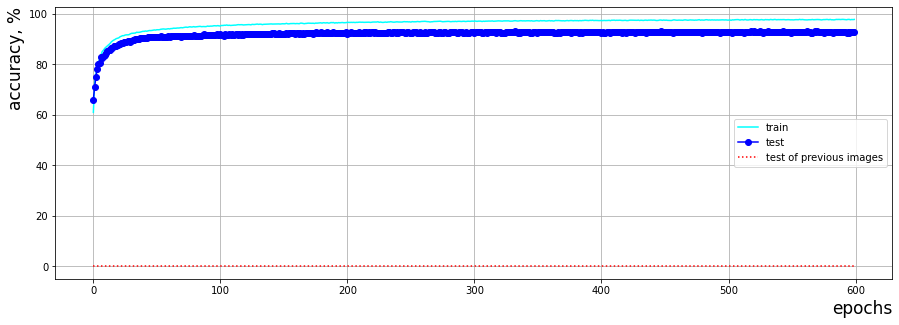

In [26]:
curve_graph(parametr_set)